In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from scipy.sparse import linalg

In [3]:
# load train and test set
import csv
import numpy as np
data = []
with open('/content/drive/My Drive/ml-100k/u.data') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
        data.append([int(row[0])-1, int(row[1])-1, int(row[2])])
data = np.array(data)
num_observations = len(data) # num_observations = 100,000
num_users = max(data[:,0])+1 # num_users = 943, indexed 0,...,942
num_items = max(data[:,1])+1 # num_items = 1682 indexed 0,...,1681
np.random.seed(1)
num_train = int(0.8*num_observations)
perm = np.random.permutation(data.shape[0])
train = data[perm[0:num_train],:]
test = data[perm[num_train::],:]

In [4]:
# specifications
num_usrs = 943
num_mvs = 1682

# create sparse matrix
train_sparse = torch.sparse_coo_tensor(train[:,0:2].T, train[:,2], (num_usrs, num_mvs))
test_sparse = torch.sparse_coo_tensor(test[:,0:2].T, test[:,2], (num_usrs, num_mvs))

# part a

In [41]:
def average_rating(train_sparse):
    '''
    train_sparse: a sparse matrix
    '''
    train = train_sparse.to_dense()
    # compute sum
    sum = torch.sum(train, dim = 0)
    # count non-zeros
    nnz = torch.sum((train != 0)*1, dim = 0)
    # compute average rating
    avr = sum / nnz
    # compute global average
    global_sum = torch.sum(train)
    global_nnz = torch.sum((train != 0)*1)
    # assign nan by global average
    avr[avr != avr] = global_sum / global_nnz

    return avr

def ar_predict_err(R, test):
    '''
    test: original index matrix
    '''
    test_pred = R[test[:,1]]
    test_err = torch.mean( (test_pred - test[:,2])**2 )

    return test_pred, test_err

In [34]:
# compute average rating estimator
Ra = average_rating(train_sparse)

In [48]:
# evaluate on test set
test_preda, test_erra = ar_predict_err(Ra, test)
print(f'The test error for this estimate is {test_erra:.6f} based on individual ratings in test set. ')

The test error for this estimate is 1.055078 based on individual ratings in test set. 


In [49]:
# compute average rating in test set
Ratest = average_rating(test_sparse)
test_erra2 = torch.mean( (Ra - Ratest)**2 )
print(f'The test error for this estimate is {test_erra2:.6f} based on all ratings in test set. ')

The test error for this estimate is 0.761050 based on all ratings in test set. 


# part b

In [16]:
# create scipy sparse matrix
train_sparse2 = sparse.csr_matrix((train[:,2], (train[:,0], train[:,1])), shape = (num_usrs, num_mvs))
test_sparse2 = sparse.csr_matrix((test[:,2], (test[:,0], test[:,1])), shape = (num_usrs, num_mvs))

In [21]:
train_sparse2 = train_sparse2.asfptype()
test_sparse2 = test_sparse2.asfptype()

In [48]:
# SVD
u, s, vh = sparse.linalg.svds(train_sparse2, k = 942)

In [37]:
def rank_k_svd(u, s, vh, k):
    '''
    Rank k approximation based on svd
    '''
    d = s.shape[0]
    sigma = np.diag(s[(d-k):d])
    return u[:,(d-k):d] @ sigma @ vh[(d-k):d]

def svd_compute_err(Rhat, test):
    '''
    test: original index matrix
    '''
    nnz = test.shape[0]
    test_pred = np.array([Rhat[test[i,0], test[i,1]] for i in range(nnz)])
    test_err = np.mean( (test_pred - test[:,2])**2 )

    return test_pred, test_err

In [53]:
# reconstruction
k_list = [1, 2, 5, 10, 20, 50]
Rhat_list = []
train_err_list = []
test_err_list = []
for ki in k_list:
    Rhat = rank_k_svd(u, s, vh, ki)
    _, train_err = svd_compute_err(Rhat, train)
    _, test_err = svd_compute_err(Rhat, test)
    Rhat_list.append(Rhat)
    train_err_list.append(train_err)
    test_err_list.append(test_err)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

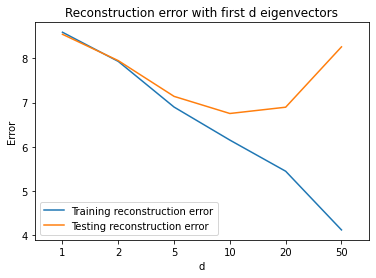

In [63]:
# plot eigenvalue distribution
figname = 'b1b'
plt.figure(figsize=(6,4))
plt.plot(torch.arange(len(k_list)), train_err_list, label = 'Training reconstruction error')
plt.plot(torch.arange(len(k_list)), test_err_list, label = 'Testing reconstruction error')
plt.title('Reconstruction error with first d eigenvectors')
plt.xlabel('d')
plt.ylabel('Error')
plt.xticks(range(len(k_list)), k_list)
plt.xlim([-0.5, len(k_list)-0.5])
plt.legend()
plt.savefig(figname+'.png', dpi = 300)
files.download(figname+'.png')
plt.show()

# part c

## definition

In [270]:
def mat_factor(train_ori, d, num_iter = 100, TOL = 1e-2, lamb = 10, sigma = 0, u0 = None, v0 = None):
    '''
    Alternating minimization for matrix factorization
    train: sparse tensor
    d: reconstruction dimension
    '''
    # create sparse matrix
    train = torch.sparse_coo_tensor(train_ori[:,0:2].T, train_ori[:,2], (num_usrs, num_mvs))
    train = train.to_dense().float()
    m, n = train.shape

    # initialize
    if u0 is None:
        u = sigma * torch.rand(m, d)
    else:
        u = torch.Tensor(u0)
    if v0 is None:
        v = sigma * torch.rand(n, d)
    else:
        v = torch.Tensor(v0)
    lambI = lamb * torch.eye(d)

    # put onto cuda
    if torch.cuda.is_available() is True:
        u = u.cuda()
        v = v.cuda()
        train = train.cuda()
        lambI = lambI.cuda()
    
    max_inner_iter = min(m, n)
    # compute first datapoint
    Rhat = u @ v.T
    err = mf_compute_err(Rhat, train_ori)
    err_list = [err]
    
    for i in range(num_iter):
        
        # alternate update
        uh, _ = torch.solve(v.T @ train.T, (v.T @ v + lambI))
        u = uh.T
        vh, _ = torch.solve(u.T @ train, (u.T @ u + lambI))
        v = vh.T
        
        # report progress
        Rhat = u @ v.T
        err = mf_compute_err(Rhat, train_ori)
        err_list.append(err)
        print(f'Iteration [{i+1}/{num_iter}]: Train error {err}. ')
        # check if converge
        if np.abs(err - err_list[-2]) < TOL:
            print(f'Converge at iteration [{i+1}/{num_iter}] with Train error {err}, d = {d}, lambda = {lamb}, sigma = {sigma}. Quit! ')
            break

    return Rhat, err_list, u, v

def mf_compute_err(Rhat, test):
    '''
    test: original index matrix
    '''
    nnz = test.shape[0]
    test_pred = torch.Tensor([Rhat[test[i,0], test[i,1]] for i in range(nnz)])
    test_err = torch.mean( (test_pred - test[:,2])**2 )

    return test_err

## k = 50, lambda = 57

In [218]:
# use solution from part b
k = 50
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

Rhatc50, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 1000, TOL = 1e-3, lamb = 57, sigma = 0, u0 = u0, v0 = v0)

Iteration [1/1000]: Train error 9.963596219482469. 
Iteration [2/1000]: Train error 7.729993506105853. 
Iteration [3/1000]: Train error 7.319858361756909. 
Iteration [4/1000]: Train error 7.145235673587187. 
Iteration [5/1000]: Train error 7.05268161160958. 
Iteration [6/1000]: Train error 7.000750540585374. 
Iteration [7/1000]: Train error 6.970079490983188. 
Iteration [8/1000]: Train error 6.951257354269308. 
Iteration [9/1000]: Train error 6.939379163075952. 
Iteration [10/1000]: Train error 6.931711805650459. 
Iteration [11/1000]: Train error 6.926663925023054. 
Iteration [12/1000]: Train error 6.923276881855336. 
Iteration [13/1000]: Train error 6.920963429603696. 
Iteration [14/1000]: Train error 6.919354577263376. 
Iteration [15/1000]: Train error 6.918216386947662. 
Iteration [16/1000]: Train error 6.917397374792087. 
Converge at iteration [16/1000] with Train error 6.917397374792087, d = 50, lambda = 57, sigma = 0. Quit! 


## k = 10, lambda = 0

In [223]:
# use solution from part b
k = 10
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

Rhatc10, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 1000, TOL = 1e-3, lamb = 0, sigma = 0, u0 = u0, v0 = v0)

Iteration [1/1000]: Train error 6.149907326899895. 
Converge at iteration [1/1000] with Train error 6.149907326899895, d = 10, lambda = 0, sigma = 0. Quit! 


## k = 20, lambda = 0.03

In [269]:
# use solution from part b
k = 20
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

Rhatc20, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 1000, TOL = 1e-3, lamb = 0.03, sigma = 0, u0 = u0, v0 = v0)

Iteration [1/1000]: Train error 5.444747657166143. 
Converge at iteration [1/1000] with Train error 5.444747657166143, d = 20, lambda = 0.03, sigma = 0. Quit! 


## k = 5, lambda = 0

In [232]:
# use solution from part b
k = 5
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

Rhatc5, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 1000, TOL = 1e-3, lamb = 0, sigma = 0, u0 = u0, v0 = v0)

Iteration [1/1000]: Train error 6.897781516605464. 
Converge at iteration [1/1000] with Train error 6.897781516605464, d = 5, lambda = 0, sigma = 0. Quit! 


## k = 2, lambda = 0.05

In [251]:
# use solution from part b
k = 2
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

Rhatc2, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 1000, TOL = 1e-6, lamb = 0.05, sigma = 0, u0 = u0, v0 = v0)

Iteration [1/1000]: Train error 7.931859812137758. 
Converge at iteration [1/1000] with Train error 7.931859812137758, d = 2, lambda = 0.05, sigma = 0. Quit! 


## k = 1, lambda = 0

In [260]:
# use solution from part b
k = 1
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

Rhatc1, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 1000, TOL = 1e-6, lamb = 0, sigma = 0, u0 = u0, v0 = v0)

Iteration [1/1000]: Train error 8.592143872623959. 
Converge at iteration [1/1000] with Train error 8.592143872623959, d = 1, lambda = 0, sigma = 0. Quit! 


## more

In [ ]:
# tune lambda
final_train_err = []
final_test_err = []
k = 20
u0 = u[:,(-k):] @ np.diag(s[(-k):])
v0h = vh[(-k):]
v0 = v0h.T

for lamb in np.arange(0.01,0.11,0.01): 
    # compute solution and error
    Rhatc, train_errc, uc, vc = mat_factor(train, d = k, num_iter = 100, TOL = 1e-6, lamb = lamb, sigma = 0, u0 = u0, v0 = v0)
    _, test_errc = mf_compute_err(Rhatc, test)
    final_train_err.append(train_errc[-1])
    final_test_err.append(test_errc)

In [271]:
train_ecc_listc = []
test_ecc_listc = []
train_ecc_listc.append(mf_compute_err(Rhatc1, train))
test_ecc_listc.append(mf_compute_err(Rhatc1, test))
train_ecc_listc.append(mf_compute_err(Rhatc2, train))
test_ecc_listc.append(mf_compute_err(Rhatc2, test))
train_ecc_listc.append(mf_compute_err(Rhatc5, train))
test_ecc_listc.append(mf_compute_err(Rhatc5, test))
train_ecc_listc.append(mf_compute_err(Rhatc10, train))
test_ecc_listc.append(mf_compute_err(Rhatc10, test))
train_ecc_listc.append(mf_compute_err(Rhatc20, train))
test_ecc_listc.append(mf_compute_err(Rhatc20, test))
train_ecc_listc.append(mf_compute_err(Rhatc50, train))
test_ecc_listc.append(mf_compute_err(Rhatc50, test))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

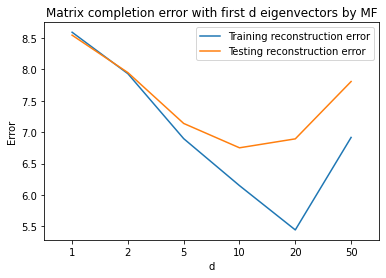

In [275]:
# plot eigenvalue distribution
figname = 'b1c'
plt.figure(figsize=(6,4))
plt.plot(torch.arange(len(k_list)), train_ecc_listc, label = 'Training reconstruction error')
plt.plot(torch.arange(len(k_list)), test_ecc_listc, label = 'Testing reconstruction error')
plt.title('Matrix completion error with first d eigenvectors by MF')
plt.xlabel('d')
plt.ylabel('Error')
plt.xticks(range(len(k_list)), k_list)
plt.xlim([-0.5, len(k_list)-0.5])
plt.legend()
plt.savefig(figname+'.png', dpi = 300)
files.download(figname+'.png')
plt.show()

# part d

In [6]:
cuda = torch.device('cuda') 

In [315]:
def sgd_mat_completion(train, d, num_epoch = 10, TOL = 1e-2, lamb = 0.01, sigma = 0, step = 1e-3, bs = 4):
    '''
    SGD for matrix factorization
    train: tensor (not sparse)
    d: reconstruction dimension
    '''
    # initialize parameters
    m = num_usrs
    n = num_mvs
    len_train = train.shape[0]
    unit_iter = np.floor(len_train / bs).astype(int) # every time a number of examples are seen that exceeds the size of the training set
    num_iter = num_epoch * unit_iter

    # initialize matrix factorization
    u0 = sigma * np.random.rand(m, d)
    v0 = sigma * np.random.rand(n, d)
    u = torch.tensor(u0, requires_grad=True, device=cuda)
    v = torch.tensor(v0, requires_grad=True, device=cuda)
    
    # record err
    err_list = []
    running_err = 0
    old_running_err = 0
    
    for i in range(num_iter):
        
        # create SGD batch
        idx = torch.randperm(len_train)[:bs]
        train_batch = torch.tensor(train[idx], dtype=torch.long, device=cuda)
        # predict
        train_pred = (u[train_batch[:,0]] * v[train_batch[:,1]]).sum(axis = 1)
        # compute loss
        mse_loss = ((train_pred - train_batch[:,2])**2).sum()
        reg_loss = lamb * ((u**2).sum() + (v**2).sum())
        loss = mse_loss + reg_loss
        err = torch.nn.functional.mse_loss(train_pred, train_batch[:,2].double())
        running_err += err
        err_list.append(err)
        # compute gradient of loss
        loss.backward()

        # converge check
        u_grad_norm = torch.linalg.norm(u.grad, float("inf"))
        v_grad_norm = torch.linalg.norm(v.grad, float("inf"))
        if (i+1)%unit_iter == 0:
            print(f'Iteration [{i+1}/{num_iter}]: loss {loss.item():.6f}, average error {running_err / unit_iter:.6f}, '
                  f'gradient u {u_grad_norm:.6f}, v {v_grad_norm:.6f}. ')
            # rescale step size
            step *= 0.9
            running_err /= unit_iter
            if running_err < TOL: 
                print(f'Error converge with d = {d}, lambda = {lamb:.4f}, sigma = {sigma:.4f}, step size = {step:.4f}, batch size = {bs}. ')
                break
            elif torch.abs(old_running_err - running_err) < 1e-3: 
                print(f'Error diff converge with d = {d}, lambda = {lamb:.4f}, sigma = {sigma:.4f}, step size = {step:.4f}, batch size = {bs}. ')
                break
            else:
                old_running_err = running_err
                if (i+1) != num_iter: 
                    running_err = 0

        # SGD update
        u.data = u.data - step * u.grad
        v.data = v.data - step * v.grad
        u.grad.zero_()
        v.grad.zero_()

    return u.data, v.data, err_list, running_err

In [ ]:
# tune hyperparameters by grid search with d = 10
# train and valid split
k = 0.8
len_train = train.shape[0]
num_train = int(len_train * k)
perm2 = np.random.permutation(len_train)
trains = train[perm2[0:num_train],:]
vals = train[perm2[num_train::],:]

# set up hyperparameters
lamb_list = [0.01, 0.009, 0.008]
bs_list = [400]
sigma_list = [1]
ss_list = [5e-3]
trains_err = np.zeros((len(lamb_list), len(bs_list), len(sigma_list), len(ss_list)))
vals_err = np.zeros((len(lamb_list), len(bs_list), len(sigma_list), len(ss_list)))

for li, lamb in zip(range(len(lamb_list)), lamb_list):
    for bi, batchsize in zip(range(len(bs_list)), bs_list):
        for gi, sigma in zip(range(len(sigma_list)), sigma_list):
            for si, stepsize in zip(range(len(ss_list)), ss_list):
                ud, vd, _, trains_err[li, bi, gi, si] = sgd_mat_completion(trains, d = 10, num_epoch = 30, 
                                        TOL = 0.7, lamb = lamb, sigma = sigma, step = stepsize, bs = batchsize)
                # predict
                valsp = (ud[vals[:,0]] * vd[vals[:,1]]).sum(axis = 1)
                # compute loss
                vals_err[li, bi, gi, si] = torch.nn.functional.mse_loss(valsp, torch.tensor(vals[:,2], device=cuda))

In [317]:
# train with optimal hyperparameter
k_list = [1, 2, 5, 10, 20, 50]
test_label = torch.tensor(test[:,2], device=cuda)
train_err_listd = []
test_err_listd = []
for ki in k_list:
    ud, vd, _, train_errd = sgd_mat_completion(train, d = 10, num_epoch = 40, 
                                        TOL = 0.7, lamb = 0.01, sigma = 1, step = 5e-3, bs = 400)
    # predict
    test_pred = (ud[test[:,0]] * vd[test[:,1]]).sum(axis = 1)
    # compute loss
    test_errd = torch.nn.functional.mse_loss(test_pred, test_label)
    train_err_listd.append(train_errd)
    test_err_listd.append(test_errd)

Iteration [200/8000]: loss 431.754394, average error 1.197200, gradient u 70.120015, v 40.909923. 
Iteration [400/8000]: loss 415.290477, average error 0.900446, gradient u 41.125370, v 43.480193. 
Iteration [600/8000]: loss 394.520342, average error 0.870404, gradient u 39.335122, v 33.949514. 
Iteration [800/8000]: loss 454.488118, average error 0.848493, gradient u 54.061559, v 37.886698. 
Iteration [1000/8000]: loss 396.718649, average error 0.836311, gradient u 48.525220, v 35.130938. 
Iteration [1200/8000]: loss 398.979018, average error 0.819470, gradient u 59.140892, v 32.591573. 
Iteration [1400/8000]: loss 425.165763, average error 0.809139, gradient u 45.775582, v 36.973000. 
Iteration [1600/8000]: loss 368.334750, average error 0.806480, gradient u 69.087851, v 36.644498. 
Iteration [1800/8000]: loss 398.559146, average error 0.795872, gradient u 46.657879, v 63.311940. 
Iteration [2000/8000]: loss 381.856741, average error 0.793382, gradient u 41.967059, v 59.700664. 
Iter

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

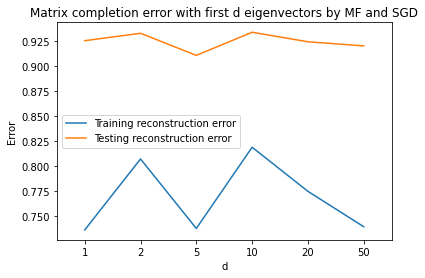

In [318]:
# plot eigenvalue distribution
figname = 'b1d'
plt.figure(figsize=(6,4))
plt.plot(torch.arange(len(k_list)), train_err_listd, label = 'Training reconstruction error')
plt.plot(torch.arange(len(k_list)), test_err_listd, label = 'Testing reconstruction error')
plt.title('Matrix completion error with first d eigenvectors by MF and SGD')
plt.xlabel('d')
plt.ylabel('Error')
plt.xticks(range(len(k_list)), k_list)
plt.xlim([-0.5, len(k_list)-0.5])
plt.legend()
plt.savefig(figname+'.png', dpi = 300)
files.download(figname+'.png')
plt.show()